# 2-grams English


We're gonna use the book *Ulysses* by James Joyce. It is available in text (utf-8) format from Project Gutenberg. First we will download it using *wget*.

In [1]:
wget -q https://www.gutenberg.org/files/4300/4300-0.txt -O /tmp/ulysses.txt

We want to get the 2-grams made of characters [a-z]. We assume there is no difference between upper and lower case characters. The transliterate *tr* (Unix) command comes at hand to do the job of removing unwanted characters (there is no need to convert upper case into lower case, since the next script already convert everything to lowercase). To compute the *n-grams* we're going to use the *ngram.awk* script available at [clscripts library](https://github.com/leolca/clscripts). The result will be stored in a file called *2grams*. 

Note: We are computing here the *2-grams* as they occur in our corpus, not on the vocabulary used in this corpus. It is easy to get the second, we just need to get unique ocurrence of words in the corpus.

In [43]:
wget -q https://raw.githubusercontent.com/leolca/clscripts/master/ngram.awk

The *ngram.awk* script was written in awk language. It might be executed using different parameters in order to accomplish different behaviours.

    ngram [-wc [-s MOD] [-n NUM]] [file]
     -w words n-grams   
     -n [num] create n-grams of n symbols (default num=2)
     -s [mode] sort - modes: 0 no sort at all, [] (empty or 1 or f) by frequency (default), 2 (or a) alphabetical
     -c case sensitive (default is case insensitive)
     
This script might read from a file or from standard input (/dev/stdin). In the following example, we're going to read from the stdin, since we want to get the output from the previous command, *tr*. We use a *pipe* to peform such action (read more about pipes here: https://en.wikipedia.org/wiki/Pipeline_(Unix)).

In [44]:
cat /tmp/ulysses.txt | tr -c 'a-zA-Z' ' ' | awk -f ngram.awk -- -n 2 -s > /tmp/2grams
head /tmp/2grams

  34162 he
  32306 th
  23327 in
  19067 er
  17936 an
  13876 re
  12918 nd
  12047 on
  11906 at
  11869 ng


Lets open the data generated in R, where we will make the computations and plots.

In [45]:
X <- read.table('/tmp/2grams',sep='', header=FALSE, stringsAsFactors=FALSE)
names(X) <- c('freq','n-gram')
summary(X)

      freq             n-gram         
 Min.   :    1.00   Length:570        
 1st Qu.:   24.25   Class :character  
 Median :  243.50   Mode  :character  
 Mean   : 1623.75                     
 3rd Qu.: 1765.75                     
 Max.   :34162.00                     

In the data we don't have all possible 2-grams. In this example, 84 of the teoretical 676 2-grams are not present (e.g. 'qa', 'qb', 'bx' and 'jy'). If all 2-grams were present, we could simply assign the values in X to a matrix, as in the commented line. Since it is not possible, we created a matrix of zeros and assigned the valus in X into this new matrix (for loop).

In [46]:
alphabet = letters[seq( from = 1, to = 26 )]
# P <- matrix(X$freq, byrow=TRUE, nrow=length(alphabet), ncol=length(alphabet), dimnames=list(alphabet, alphabet))
P <- matrix(0, nrow=length(alphabet), ncol=length(alphabet), dimnames=list(alphabet, alphabet))
for(i in 1:length(X[[1]])){ 
    ngram <- strsplit(X[[i,2]],'')
    P[ngram[[1]][1], ngram[[1]][2]] <- X[[i,1]]
}

In [47]:
#normalize <- function(x){
#    (x-min(x))/(max(x)-min(x))
#}
#Pn <- apply(P,1:2,normalize)
Pn <- P/rowSums(P)

Conditional probability distributions. In $P(y|x)$ each row shows the conditional distribution of the second letter, y, given the first letter, x, in a bigram xy.

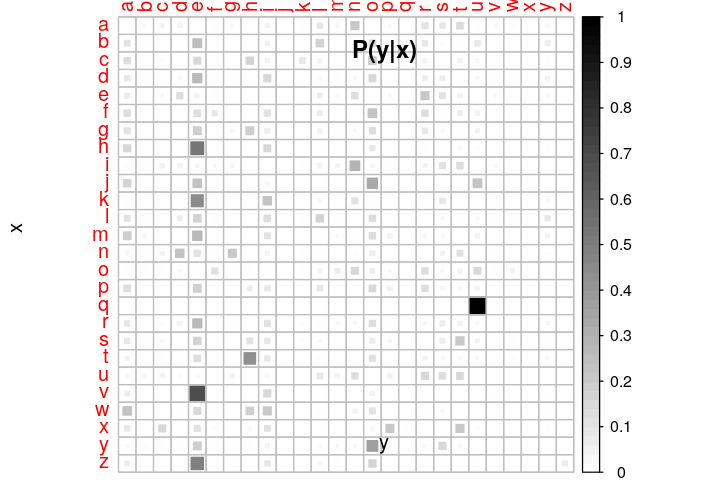

In [48]:
library(corrplot)
corrplot(Pn,  is.corr = FALSE, method = "square", col=colorRampPalette(c("white","white","black"))(100))
title(main = "P(y|x)", xlab = "y", ylab = "x")

In [20]:
#logPn <- log10(1+Pn)
#logPn <- apply(logPn,1:2,function(x) {
#    if(any(is.infinite(x))) {
#         x[is.infinite(x)] <- 0
#    }
#    return(x)
#})
#corrplot(20*logPn, is.corr = FALSE, method = "square")

## H(X,Y)  - joint entropy 

Let's compute now the joint entropy H(X,Y). First we need to divide the matriz of 2-grams counts by the total count, in order to approach the joint probability. Then we define the entropy function:

$ H(X) = - \sum_x p(x) \log_2(p(x)) $

and the joint entropy function:

$ H(X,Y) = - \sum_{x,y} p(x,y) \log_2(p(x,y)) $

Note that, to compute both, we might use the same code (in R).

In [62]:
pxy <- P/sum(P)
entropy <- function(x) { x <- x[x!=0]; -sum(x * log2(x)) }
HXY <- entropy(pxy)
print(sprintf("H(X,Y) = %.2f bits",HXY))

[1] "H(X,Y) = 7.50 bits"


To compute $H(X)$ and $H(Y)$ we still need to get the marginals $p(x)$ and $p(y)$, respectively.

In [63]:
px <- rowSums(pxy)
py <- colSums(pxy)

HX <- entropy(px)
print(sprintf("H(X) = %.2f bits",HX))

HY <- entropy(py)
print(sprintf("H(Y) = %.2f bits",HY))

[1] "H(X) = 4.19 bits"
[1] "H(Y) = 4.10 bits"


Lets make a bar plot showing the approximated p.m.f. of X and Y, where we are considering the 2-grams xy (x is the first letter and y the second). 

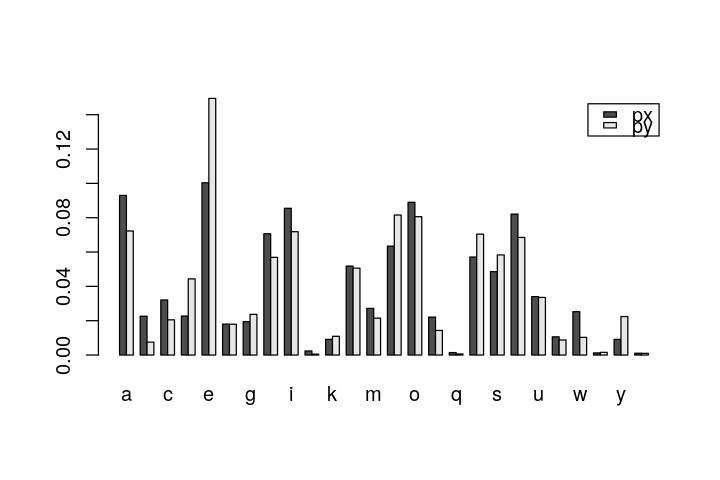

In [53]:
set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
        }

set_plot_dimensions(6, 4)
barplot(rbind(px,py),beside=T,legend=c("px","py"))

In order to compute the conditional entropy H(Y|X), 

$ H(Y|X) = -\sum_{x,y} p(x,y) \log p(y|x) $

we need to get the conditional probability first:

$ p(y|x) = \frac{p(x,y)}{p(x)} $

In [69]:
pygx <- apply(pxy, 2, "/", px)
pxgy <- apply(pxy, 2, "/", py)

In [67]:
divide <- function(x,y) {  # makes x / y and return 0 when find 0/0
    z = x/y
    z[is.nan(z)] <- 0
    return(z)
}

conditional_entropies <- function(pxy) {
    px <- rowSums(pxy)
    py <- colSums(pxy)
    pygx <- apply(pxy, 2, divide, px)
    pxgy <- apply(pxy, 2, divide, py)
    tmp <- pxy * log2(pygx)
    tmp[is.nan(tmp)] <- 0
    hygx <- -sum(tmp)
    tmp <- pxy * log2(pxgy)
    tmp[is.nan(tmp)] <- 0
    hxgy <- -sum(tmp)
    return ( list(HYgX=hygx , HXgY=hxgy) )
}

HH <- conditional_entropies(pxy)

print(sprintf("H(Y|X) = %.2f bits",HH$HYgX))
print(sprintf("H(X|Y) = %.2f bits",HH$HXgY))

print("H(X,Y) - H(Y|X) = H(X)")
print(sprintf("%.3f - %.3f = %.3f",HXY,HH$HYgX,HX))
print(sprintf("%.3f = %.3f",HXY - HH$HYgX,HX))

[1] "H(Y|X) = 3.32 bits"
[1] "H(X|Y) = 3.23 bits"
[1] "H(X,Y) - H(Y|X) = H(X)"
[1] "7.504 - 3.316 = 4.188"
[1] "4.188 = 4.188"
